# **Modele Machine Learning**


### Instalacja niezbędnych pakietów

*   analiza
*   modele
*   wizualizacja


In [1]:
from IPython.display import clear_output
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import re
import numpy as np
import string
import time
import pickle


import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt


from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV


!pip install argparse #Argparse 3.2
!pip install xtract #Xtract 0.1 a3
clear_output()

## Dane

*   dane zostały wcześniej poddane prepocessingowi
*   ładowanie czystych danych



In [2]:
#Authenticate
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
path = '/content/drive/MyDrive/ZUM projekt/clean_data.csv'   
clean_data = pd.read_csv(path, delimiter = ",", encoding='utf-8')
clean_data.head()

,tweet,clean_text,cleaned_text,sentiment,sentiments_val
0,"Kiedy #coronavirus dotrze do Polski, napotka o...","['coronavirus', 'dotrze', 'polski', 'napotka',...",coronavirus dotrze polski napotka op znakomici...,1,positive
1,Kolejni Polacy chcą wrócić z Wuhan https://t.c...,"['kolejni', 'polacy', 'chc', 'wr', 'wuhan']",kolejni polacy chc wr wuhan,1,positive
2,A tymczasem w Wuhan odcięto od reszty świata o...,"['tymczasem', 'wuhan', 'odci', 'reszty', 'wiat...",tymczasem wuhan odci reszty wiata obszar por w...,0,negative
3,@PatrykWachowiec @KancelariaSejmu nie zdziwię ...,"['zdziwi', 'si', 'powiedz', 'listy', 'pojecha'...",zdziwi si powiedz listy pojecha chin wuhan odw...,1,positive
4,".@MSZ_RP: 19 Polaków chce wrócić z Wuhan, w am...","['rp', 'polak', 'wr', 'wuhan', 'ambasadzie', '...",rp polak wr wuhan ambasadzie rp pekinie powo a...,1,positive


## Podział na dane testowe, treningowe i walidacyjne

In [5]:
X = clean_data['cleaned_text'].values.astype('U')
Y = clean_data['sentiment'].values.astype('U')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state =37)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state =37)

In [6]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=485087)
vectors = vectorizer.fit_transform(X_train, X_test)


In [7]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [8]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_validation = y_validation.astype(int)

## Model ewaluacji wyników

In [9]:
def model_Evaluate(model):
  # Predykcja danych na danych testowych
  y_pred = model.predict(X_test)

  # Wyświetlenie metryk ewaluacji na podstawie predykcji i ground truth (faktycznych etykiet)
  print(classification_report(y_test, y_pred))

  # Obliczamy i wyświetlamy confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative', 'Positive']
  group_names = ['True Neg', 'False Pos', 'False Neg','True Pos' ]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
              xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Algorytm 1 - Bernoulli Naive Bayes (BernoulliNB)


              precision    recall  f1-score   support

           0       0.93      0.74      0.83     19429
           1       0.85      0.96      0.90     28937

    accuracy                           0.88     48366
   macro avg       0.89      0.85      0.86     48366
weighted avg       0.88      0.88      0.87     48366



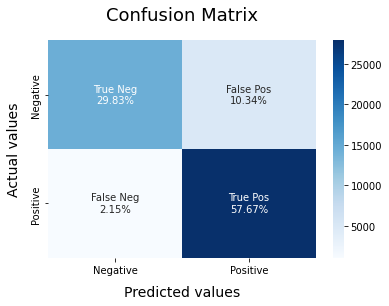

In [10]:
BNBmodel = BernoulliNB(alpha = 2)
y_pred1 = BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

## Algorytm 2 - Linear Support Vector Classification



              precision    recall  f1-score   support

           0       0.94      0.91      0.93     19429
           1       0.94      0.96      0.95     28937

    accuracy                           0.94     48366
   macro avg       0.94      0.94      0.94     48366
weighted avg       0.94      0.94      0.94     48366



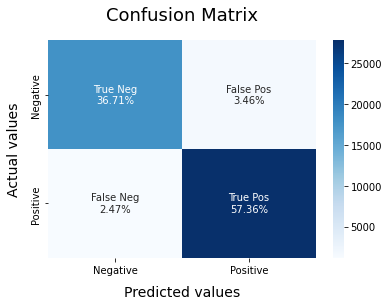

In [11]:
svm = LinearSVC(random_state=0)
clf = CalibratedClassifierCV(svm) 
y_pred2 = clf.fit(X_train, y_train)
model_Evaluate(clf)

## Algorytm 3 - Logistic Regression

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     19429
           1       0.92      0.95      0.93     28937

    accuracy                           0.92     48366
   macro avg       0.92      0.91      0.92     48366
weighted avg       0.92      0.92      0.92     48366



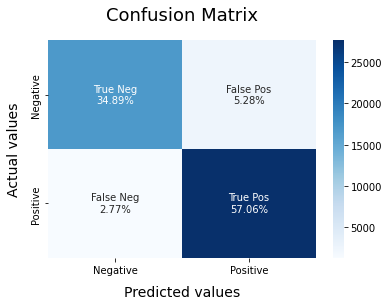

In [12]:
# define and fit the model
LRmodel = LogisticRegression(max_iter = 1000)
y_pred3 = LRmodel.fit(X_train, y_train).decision_function(X_test)
model_Evaluate(LRmodel)

### ROC Curve

In [13]:
# predict probabilities
pred_prob1 = BNBmodel.predict_proba(X_test)
pred_prob2 = clf.predict_proba(X_test)
pred_prob3 = LRmodel.predict_proba(X_test)

In [14]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [15]:
# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])

print(auc_score1, auc_score2, auc_score3)

0.961789484253084 0.9856354843630805 0.979150739726956


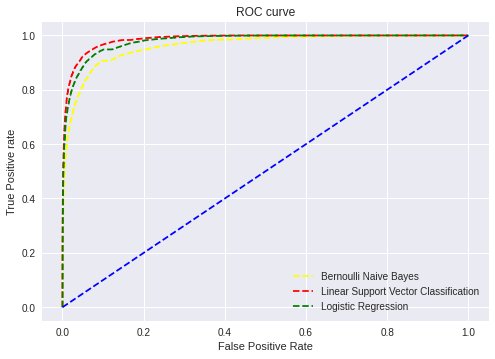

In [17]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='yellow', label='Bernoulli Naive Bayes')
plt.plot(fpr2, tpr2, linestyle='--',color='red', label='Linear Support Vector Classification')
plt.plot(fpr3, tpr3, linestyle='--',color='green', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();